Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil
import numpy as np

from PIL import Image, ImageOps

Helper Functions

In [ ]:
def denorm(tensor):
  return tensor * stats[0] * stats[1]

def show(tensor, num):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=4).permute(1,2,0).clip(0,1)
  plt.imshow(grid)
  plt.show()

Hyperparameters

In [ ]:
# Hyperparameters
stats = (0.1307), (0.3081)
bs = 64
epochs = 10
device = ( 'cuda' if torch.cuda.is_available() else 'cpu' )

# MNIST dataset parameters
mean_gray = 0.1307
stdd_gray = 0.3081

Datasets and Dataloaders

In [ ]:
transformation = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Normalize((mean_gray,),(stdd_gray,)),
    #transforms.Resize([64,64])
])

transformation2 = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Normalize((mean_gray,),(stdd_gray,)),
])


train_dataset = datasets.MNIST(
    root = 'data',
    download = True,
    train = True,
    transform = transformation
)

test_dataset = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transformation
)

100%|██████████| 9912422/9912422 [00:00<00:00, 236333056.19it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 34769142.89it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64316522.95it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 9229907.35it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



select indexes of data to be removed (imbalanced dataset creation)

In [ ]:
selection = (train_dataset.targets[:10] == 5)
selection_h = (train_dataset.targets == 5)
print(selection_h)

print((train_dataset.targets[:100] == 5).nonzero(as_tuple=True)[0])

remove_idx = ((train_dataset.targets == 5).nonzero(as_tuple=True)[0])
num = remove_idx.shape[0]
num = ceil(0.99 * num)
print(f'num {num}')
to_remove = remove_idx[:num]
print(f'remove_idx.shape {remove_idx.shape}')

remove_idx_test = ((test_dataset.targets == 5).nonzero(as_tuple=True)[0])
num2 = remove_idx_test.shape[0]
num2 = ceil(0.8 * num2)
print(f'num2 {num2}')
to_remove_test = remove_idx_test[:num2]

tensor([ True, False, False,  ...,  True, False, False])
tensor([ 0, 11, 35, 47, 65])
num 5367
remove_idx.shape torch.Size([5421])
num2 714


Custom Imbalanced dataset Declaration

In [ ]:
class MyDataset(Dataset):
  def __init__(self,remove_list, transform = None, train=True):
    self.mnist = datasets.MNIST(root='./data',
                                download=True,
                                train=train,
                                transform=None)
    self.data = self.mnist.data
    self.targets = self.mnist.targets
    self.transform = transform
    mask = np.ones(len(self.data), dtype=bool)
    mask[remove_list] = False

    self.data = self.data[mask]
    self.targets = self.targets[mask]
    #print(self.data[0].shape)

  def __getitem__(self, index):
    #data, target = self.final_data[index], self.final_targets[index]
    data, target = self.data[index], self.targets[index]
    #data = data.view(-1, 28, 28)
    data = self.transform(np.array(data))
    return data, target

  def __len__(self):
    #return len(self.final_data)
    return len(self.data)

  #def __remove__(self, remove_list):
  #  data = np.delete(self.data, remove_list, axis = 0)
  #  targets = np.delete(self.targets, remove_list, axis = 0)

 #   return data, targets

In [ ]:
# Imbalanced datasets

#### Use this tranformation for traditional data augmentation
transformation3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
])

traindat = MyDataset(to_remove, transformation, True)
#testdat = MyDataset(to_remove_test, transformation, train=False)
#print(train_dataset.targets[:12])
#print(traindat.targets[:12])

trainloader = DataLoader(
    #dataset = train_dataset,
    dataset = traindat,
    batch_size = bs,
    shuffle = True
)

print(len((traindat.targets == 5).nonzero(as_tuple=True)[0]))

54


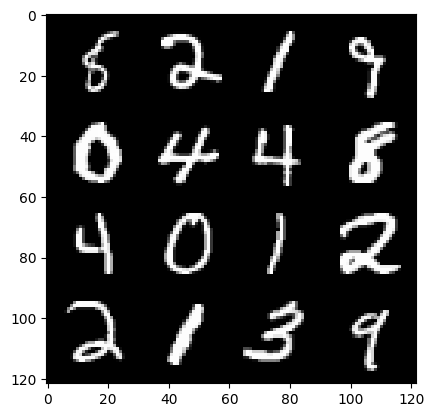

In [ ]:
ha, _ = next(iter(trainloader))
show(ha, 16)

In [ ]:
import os
import PIL
import pandas as pd

#img_path = '/content/drive/MyDrive/generated_mnist'
img_path = '/content/drive/MyDrive/generated_mnist_aug3'   # augmented
label_path = f'{img_path}/labels/labels.csv'
fcount = 0
file1 = ''
labels = []
label = []

#sorted = os.listdir(img_path)
#print(sorted[:20])

for file in os.listdir(img_path):
  if os.path.isfile(os.path.join(img_path, file)):
    #file1 = os.path.join(path, file)
    labels.append(file)
    label.append(5)
    fcount += 1

# images names
df = pd.DataFrame(labels)
# label name (5 for all)
df2 = pd.DataFrame(label)

frames = [df, df2]
result = pd.concat(frames, axis =1)

result.to_csv(label_path, index=None)

print(result.head())

        0  0
0  00.png  5
1  02.png  5
2  03.png  5
3  04.png  5
4  05.png  5


In [ ]:
test = pd.read_csv(label_path, index_col=None)
test.head()
#print(test.iloc[0][1])

,0,0.1
0,00.png,5
1,02.png,5
2,03.png,5
3,04.png,5
4,05.png,5


In [ ]:
from torchvision.io import read_image

# 1. Dataset Class
class DatasetTwo(Dataset):
  def __init__(self, img_dir, annotations_file, transform=None):
    self.img_dir = img_dir
    self.img_labels = pd.read_csv(annotations_file,index_col=False)
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    data = PIL.Image.open(img_path)
    data = ImageOps.grayscale(data)
    #data = read_image(img_path)
    data = self.transform(data)
    label = self.img_labels.iloc[idx, 1]
    label = torch.from_numpy(np.asarray(label))
    #print(label)
    return data, label

  def haha(self):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[3][0])
    label = self.img_labels.iloc[3,1]
    print(img_path, label)

In [ ]:
dotoset = DatasetTwo(img_path, label_path, transform = transformation2)
len(dotoset)

146

In [ ]:
trainloader2 = DataLoader(
    #dataset = train_dataset,
    dataset = dotoset,
    batch_size = bs,
    shuffle = True
)

146
torch.Size([64, 1, 28, 28])


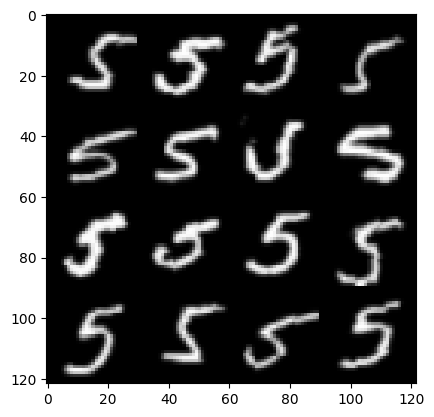

In [ ]:
img, label = next(iter(trainloader2))
print(len(dotoset))
print(img.shape)
show(img, 16)

In [ ]:
train_dev_sets = torch.utils.data.ConcatDataset([traindat, dotoset])
train_dev_loader = DataLoader(dataset=train_dev_sets, batch_size = bs, shuffle=True)

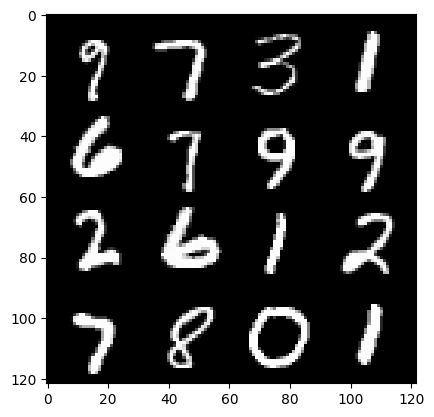

In [ ]:
imgs, labels = next(iter(train_dev_loader))

show(imgs, 16)

In [ ]:
trainloader = DataLoader(
    dataset = traindat,
    #dataset = testdat,
    batch_size = bs,
    shuffle = False
)

testloader = DataLoader(
    dataset = test_dataset,
    #dataset = testdat,
    batch_size = bs,
    shuffle = False
)

Dataset Visualization

torch.Size([64, 1, 28, 28])


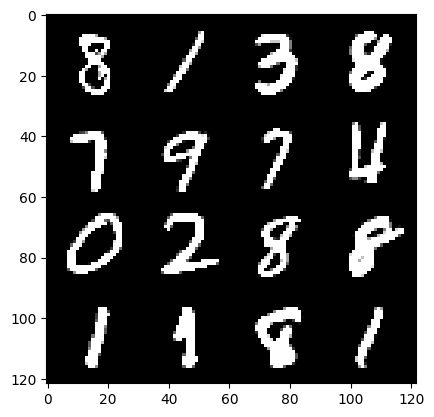

In [ ]:
# dataset visualization
ha, labels = next(iter(trainloader))

print(ha.shape)
show(ha, 16)

Model Creation

In [ ]:
# Model Architecture

def convBlock(inp, out, f, s, p):
  return nn.Sequential(
      nn.Conv2d(inp, out, f, s, p),
      nn.BatchNorm2d(out),
      nn.ReLU(inplace=True),
      nn.Dropout(0.2)
  )

def linBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.ReLU(inplace=True),
      nn.Dropout(0.5)
  )

class CnnNet(nn.Module):
  def __init__(self, d_dim=8):
    super(CnnNet, self).__init__()
    self.d_dim = d_dim

    self.cnn_model = nn.Sequential(
        # input 28 x 28 x 1
        convBlock(1, d_dim, 3, 1, 1),         # 28 x 28 x 8
        nn.MaxPool2d(2),                      # 14 x 14 x 8
        convBlock(d_dim, d_dim*4, 5, 1 , 2),  # 14 x 14 x 32
        nn.MaxPool2d(2),                      # 7 x 7 x 32
    )

    self.lin_model = nn.Sequential(
        linBlock(1568, 600),                  # 7 x 7 x 32 = 1568
        #linBlock(8192, 600),
        nn.Linear(600, 10),
        #nn.Sigmoid()
    )

  def forward(self, x):
    out = self.cnn_model(x)

    # Flatten input in order to feed it to the linear layers
    out = out.view(-1, 1568)
    #out = out.view(-1, 8192)
    out = self.lin_model(out)

    return out

Model & Loss Function Init

In [ ]:
model = CnnNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
print(model.parameters)

<bound method Module.parameters of CnnNet(
  (cnn_model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.2, inplace=False)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lin_model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1568, out_features=600, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
    )
    (1): Linear(in_features=600, out_fea

Training Loop

 98%|█████████▊| 842/856 [00:15<00:00, 149.47it/s]


 Epoch: 0: Step 854: Model loss: 0.03709004446864128


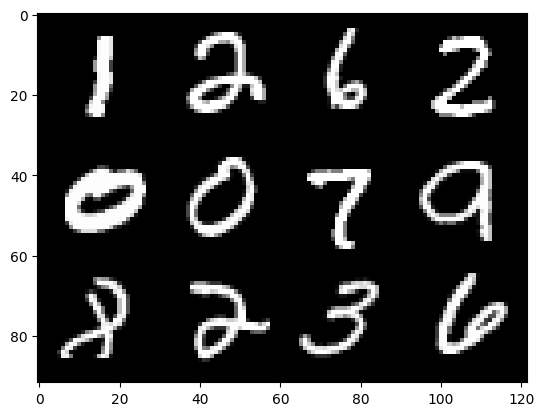


 tensor([ 2,  3,  7,  3,  1,  1,  8, 10,  9,  3,  4,  7], device='cuda:0')


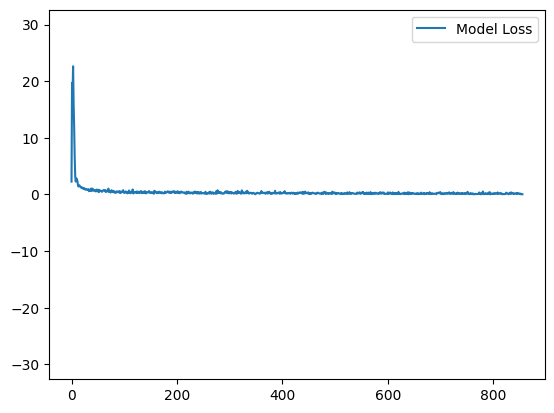

100%|██████████| 157/157 [00:01<00:00, 79.72it/s]


Epoch 1/20, train loss 0.41606956833612313, train acc 90.3083298344256
 test loss 0.2343928621263261, test acc 91.88


 99%|█████████▊| 844/856 [00:06<00:00, 152.85it/s]


 Epoch: 1: Step 854: Model loss: 0.03709004446864128


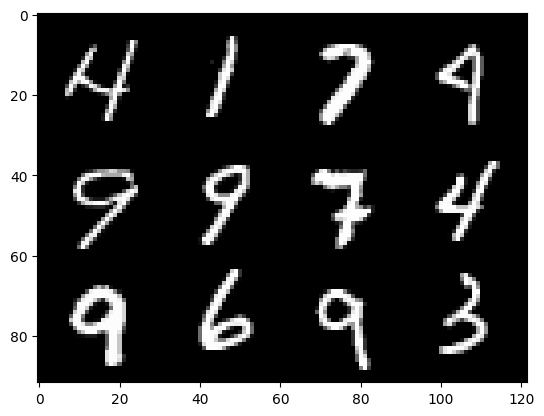


 tensor([ 5,  2,  8, 10, 10, 10,  8,  5, 10,  7, 10,  4], device='cuda:0')


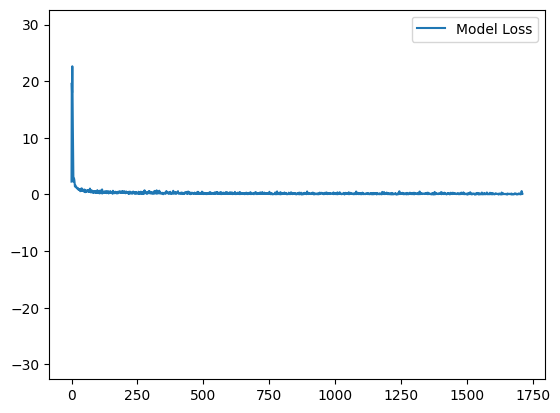

100%|██████████| 157/157 [00:01<00:00, 100.67it/s]


Epoch 2/20, train loss 0.12767903355089513, train acc 96.43659066430567
 test loss 0.09907126565412677, test acc 96.94


100%|█████████▉| 853/856 [00:06<00:00, 114.63it/s]


 Epoch: 2: Step 854: Model loss: 0.03709004446864128


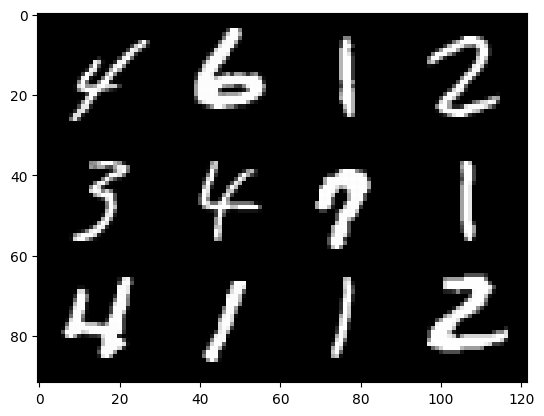


 tensor([5, 7, 2, 3, 4, 5, 8, 2, 5, 2, 2, 3], device='cuda:0')


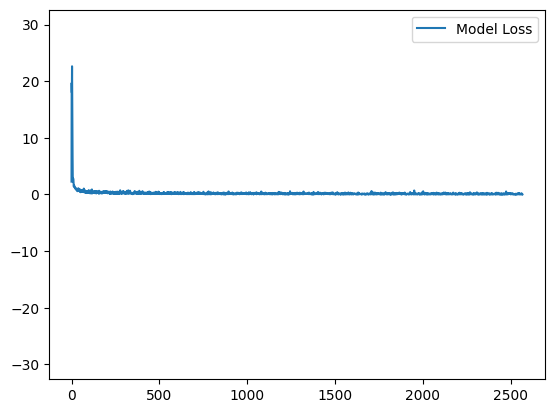

100%|██████████| 157/157 [00:01<00:00, 102.84it/s]


Epoch 3/20, train loss 0.10026179357795219, train acc 97.18140163201227
 test loss 0.21930798930916817, test acc 94.18


100%|█████████▉| 852/856 [00:05<00:00, 139.24it/s]


 Epoch: 3: Step 854: Model loss: 0.03709004446864128


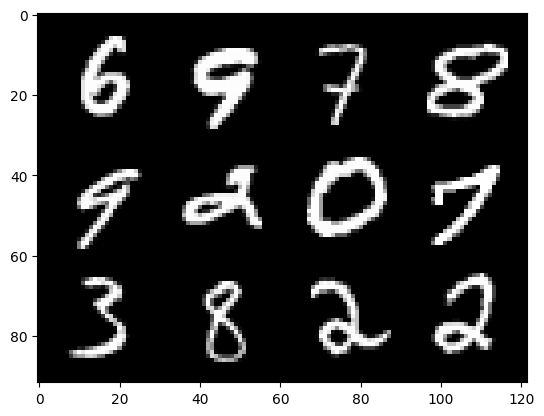


 tensor([ 7, 10,  8,  9, 10,  3,  1,  8,  4,  9,  3,  3], device='cuda:0')


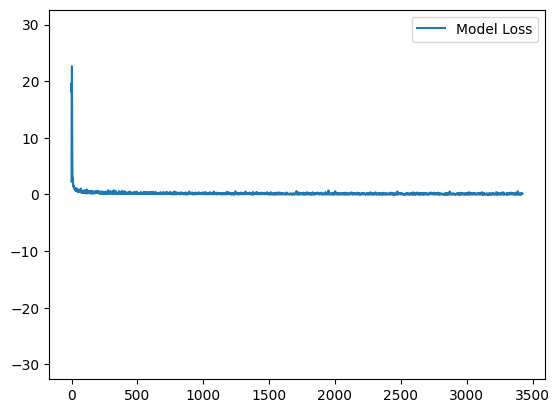

100%|██████████| 157/157 [00:01<00:00, 102.93it/s]


Epoch 4/20, train loss 0.0946320411087378, train acc 97.38038299348291
 test loss 0.11452254257127821, test acc 96.65


 98%|█████████▊| 841/856 [00:06<00:00, 140.02it/s]


 Epoch: 4: Step 854: Model loss: 0.03709004446864128


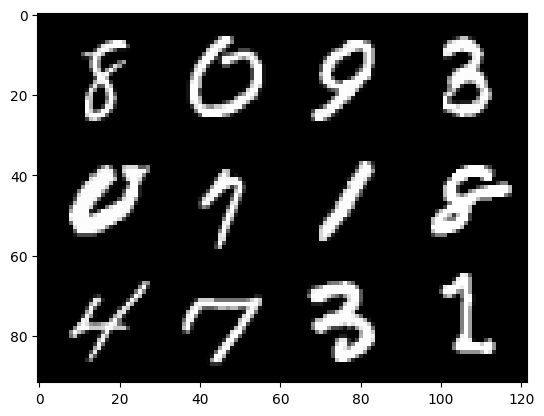


 tensor([9, 1, 6, 4, 1, 8, 2, 9, 5, 8, 4, 3], device='cuda:0')


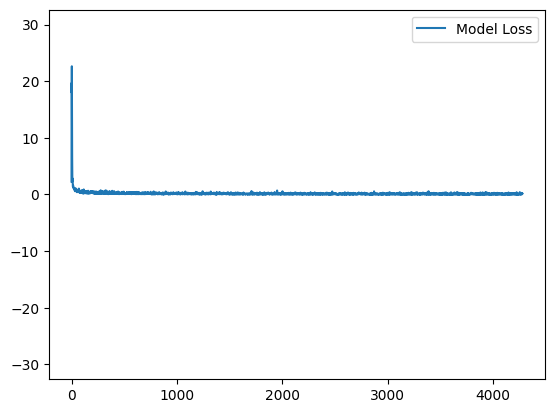

100%|██████████| 157/157 [00:01<00:00, 105.95it/s]


Epoch 5/20, train loss 0.0854559008631636, train acc 97.67976779422771
 test loss 0.15150506691310175, test acc 95.35


 99%|█████████▉| 847/856 [00:07<00:00, 90.70it/s]


 Epoch: 5: Step 854: Model loss: 0.03709004446864128


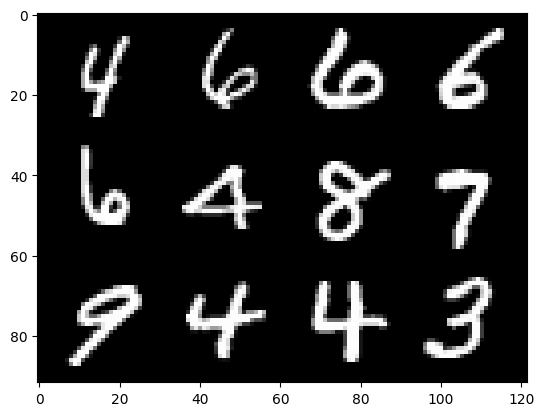


 tensor([ 5,  7,  7,  7,  7,  5,  9,  8, 10,  5,  5,  4], device='cuda:0')


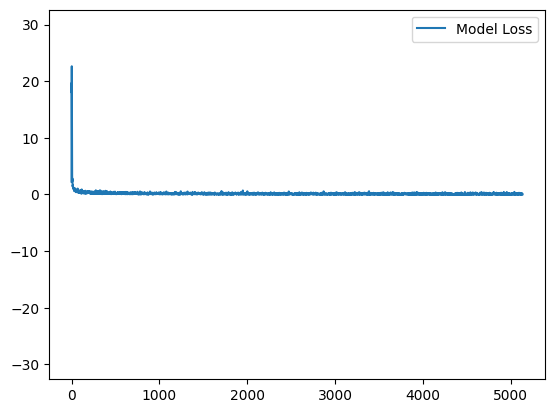

100%|██████████| 157/157 [00:01<00:00, 89.95it/s] 


Epoch 6/20, train loss 0.08196691988811164, train acc 97.76191606272477
 test loss 0.13333260611808287, test acc 96.33


100%|█████████▉| 853/856 [00:06<00:00, 144.09it/s]


 Epoch: 6: Step 854: Model loss: 0.03709004446864128


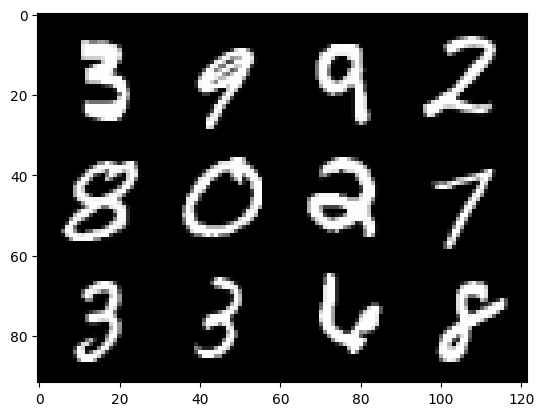


 tensor([ 4, 10, 10,  3,  9,  1,  3,  8,  4,  4,  7,  9], device='cuda:0')


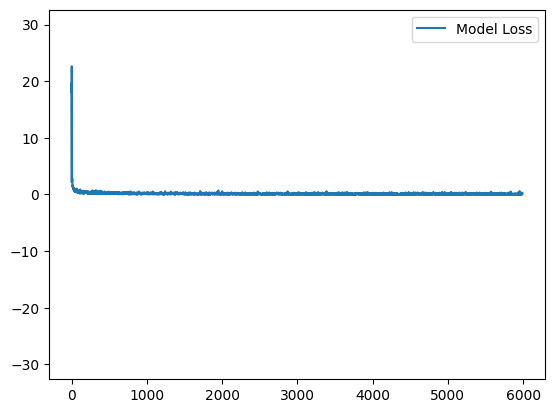

100%|██████████| 157/157 [00:01<00:00, 103.49it/s]


Epoch 7/20, train loss 0.08415318514404288, train acc 97.80207743843444
 test loss 0.0965357669069325, test acc 97.34


 99%|█████████▉| 851/856 [00:06<00:00, 145.79it/s]


 Epoch: 7: Step 854: Model loss: 0.03709004446864128


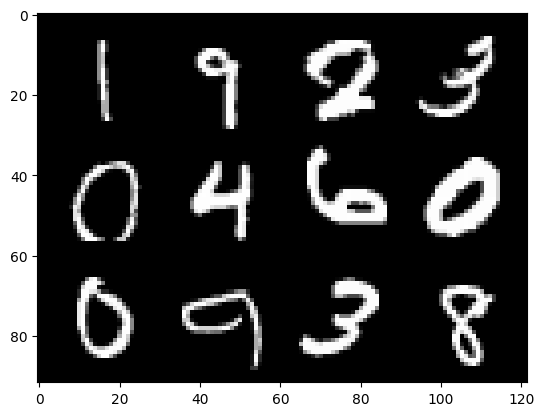


 tensor([ 2, 10,  3,  4,  1,  5,  7,  1,  1, 10,  4,  9], device='cuda:0')


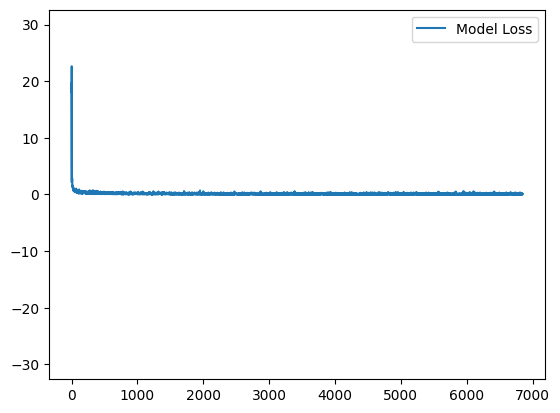

100%|██████████| 157/157 [00:01<00:00, 104.86it/s]


Epoch 8/20, train loss 0.07534514295993831, train acc 97.99923328282736
 test loss 0.22814341882395017, test acc 94.56


 99%|█████████▉| 848/856 [00:06<00:00, 117.99it/s]


 Epoch: 8: Step 854: Model loss: 0.03709004446864128


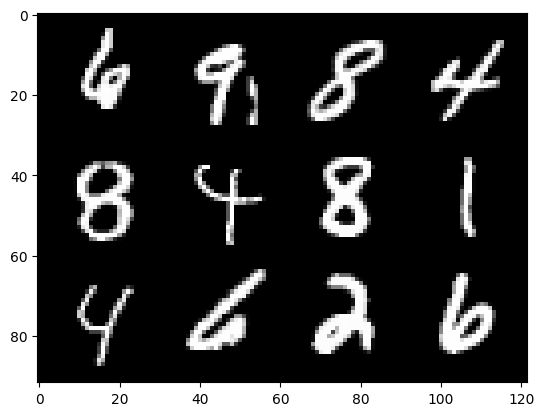


 tensor([ 7, 10,  9,  5,  9,  5,  9,  2,  5,  1,  3,  7], device='cuda:0')


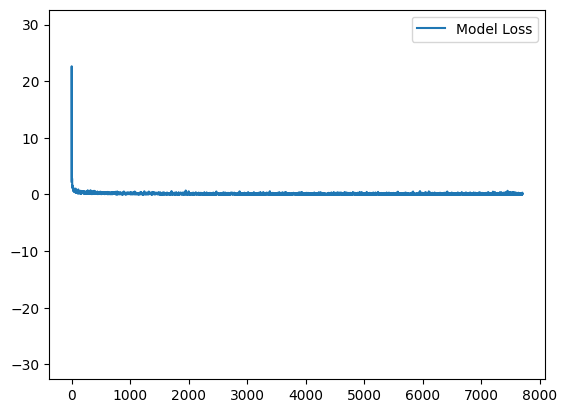

100%|██████████| 157/157 [00:02<00:00, 72.74it/s]


Epoch 9/20, train loss 0.0783578821721217, train acc 97.99923328282736
 test loss 0.10851813542675973, test acc 96.99


 99%|█████████▉| 847/856 [00:06<00:00, 147.52it/s]


 Epoch: 9: Step 854: Model loss: 0.03709004446864128


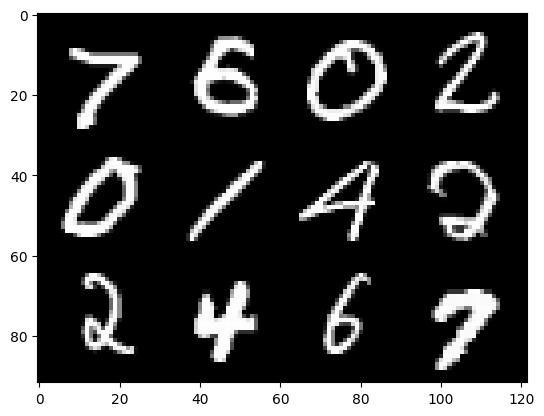


 tensor([8, 7, 1, 3, 1, 2, 5, 8, 3, 5, 7, 8], device='cuda:0')


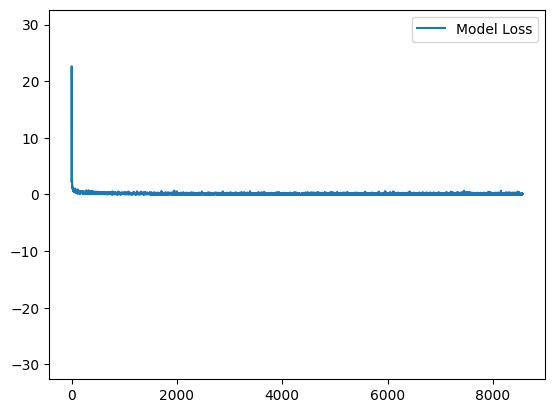

100%|██████████| 157/157 [00:01<00:00, 102.40it/s]


Epoch 10/20, train loss 0.07564820890752556, train acc 98.00105879990507
 test loss 0.17344802892566688, test acc 96.01


100%|█████████▉| 853/856 [00:06<00:00, 141.04it/s]


 Epoch: 10: Step 854: Model loss: 0.03709004446864128


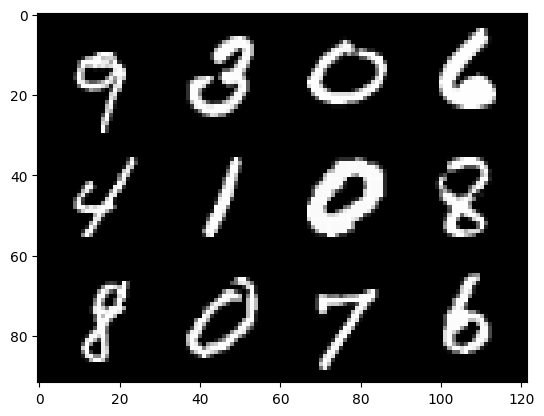


 tensor([10,  4,  1,  7,  5,  2,  1,  9,  9,  1,  8,  7], device='cuda:0')


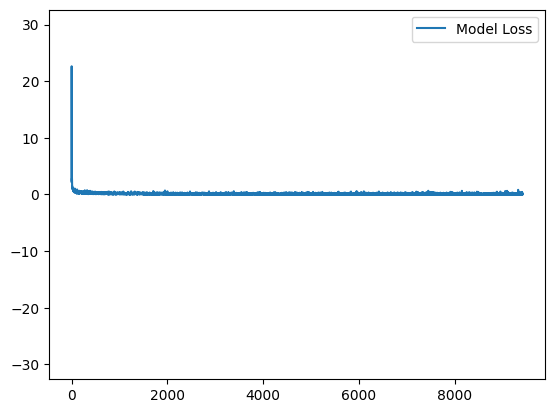

100%|██████████| 157/157 [00:01<00:00, 102.88it/s]


Epoch 11/20, train loss 0.07509750659021094, train acc 97.94264225341827
 test loss 0.12849212174782004, test acc 96.92


100%|█████████▉| 853/856 [00:06<00:00, 136.85it/s]


 Epoch: 11: Step 854: Model loss: 0.03709004446864128


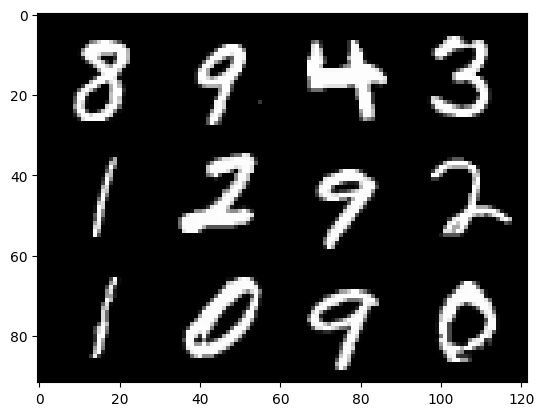


 tensor([ 9, 10,  5,  4,  2,  3, 10,  3,  2,  1, 10,  1], device='cuda:0')


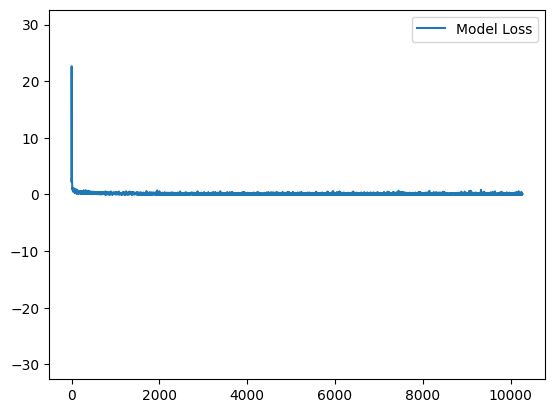

100%|██████████| 157/157 [00:02<00:00, 73.66it/s]


Epoch 12/20, train loss 0.07253558479217041, train acc 98.15257671735519
 test loss 0.12145715470115027, test acc 97.12


 99%|█████████▉| 846/856 [00:06<00:00, 144.21it/s]


 Epoch: 12: Step 854: Model loss: 0.03709004446864128


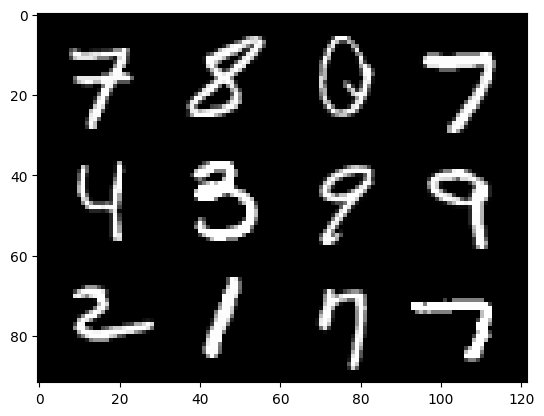


 tensor([ 8,  9,  7,  8,  5,  4, 10, 10,  3,  2,  8,  8], device='cuda:0')


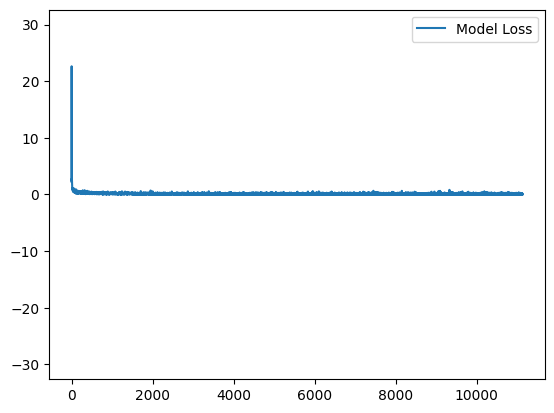

100%|██████████| 157/157 [00:01<00:00, 102.14it/s]


Epoch 13/20, train loss 0.06671182667995412, train acc 98.28766498110589
 test loss 0.17899951071870124, test acc 96.68


100%|█████████▉| 852/856 [00:06<00:00, 112.60it/s]


 Epoch: 13: Step 854: Model loss: 0.03709004446864128


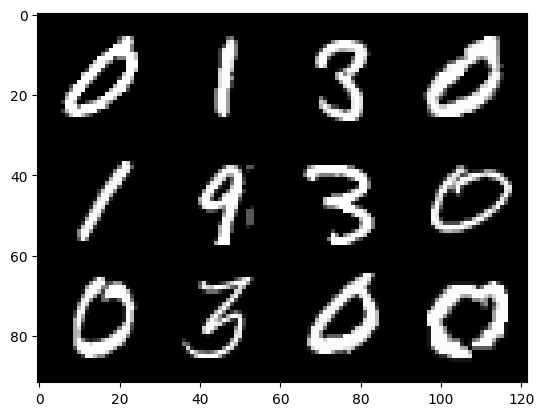


 tensor([ 1,  2,  4,  1,  2, 10,  4,  1,  1,  4,  1,  1], device='cuda:0')


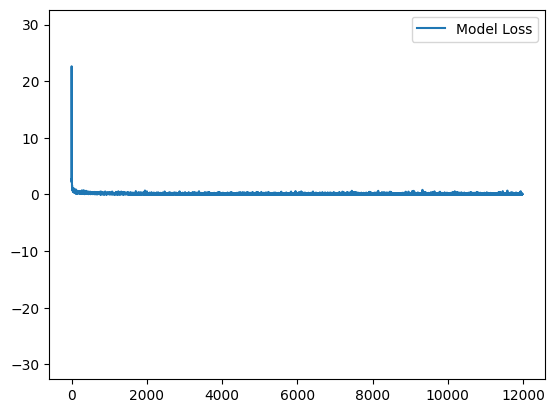

100%|██████████| 157/157 [00:01<00:00, 103.20it/s]


Epoch 14/20, train loss 0.06827682152038293, train acc 98.26758429325106
 test loss 0.11928380633593881, test acc 97.12


 98%|█████████▊| 840/856 [00:05<00:00, 148.69it/s]


 Epoch: 14: Step 854: Model loss: 0.03709004446864128


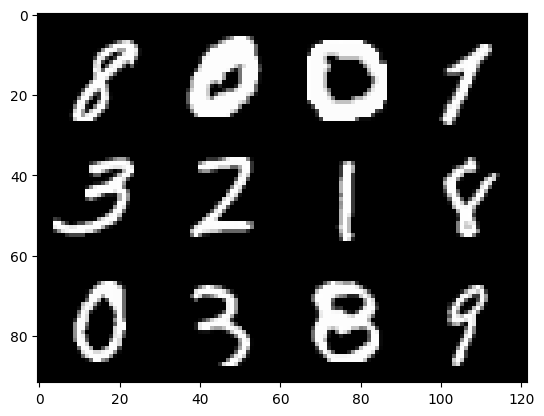

100%|█████████▉| 855/856 [00:06<00:00, 96.88it/s] 


 tensor([ 9,  1,  1,  2,  4,  3,  2,  9,  1,  4,  9, 10], device='cuda:0')


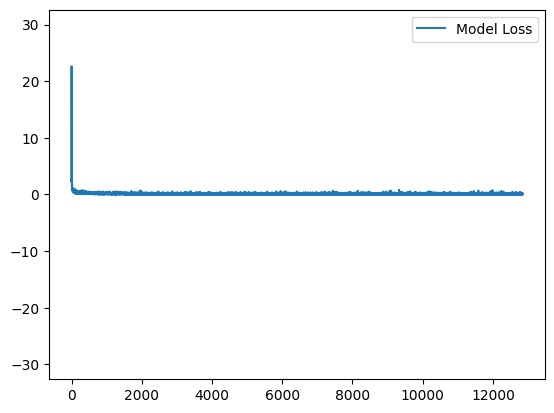

100%|██████████| 157/157 [00:01<00:00, 99.09it/s]


Epoch 15/20, train loss 0.07259596011433597, train acc 98.15987878566604
 test loss 0.17783427224773818, test acc 96.67


 99%|█████████▉| 846/856 [00:06<00:00, 142.00it/s]


 Epoch: 15: Step 854: Model loss: 0.03709004446864128


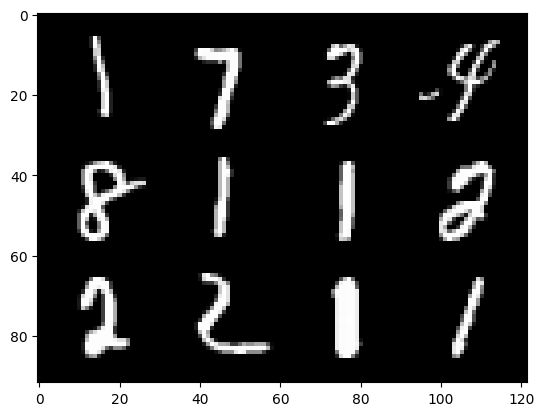


 tensor([2, 8, 4, 5, 9, 2, 2, 3, 3, 3, 2, 2], device='cuda:0')


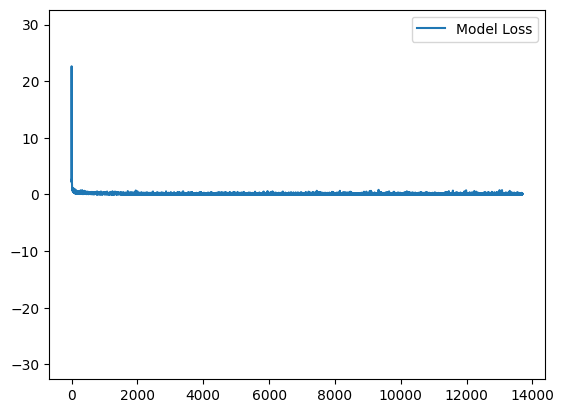

100%|██████████| 157/157 [00:01<00:00, 101.90it/s]


Epoch 16/20, train loss 0.0683372353056112, train acc 98.25298015662936
 test loss 0.09621003933712655, test acc 97.58


 99%|█████████▉| 849/856 [00:06<00:00, 112.74it/s]


 Epoch: 16: Step 854: Model loss: 0.03709004446864128


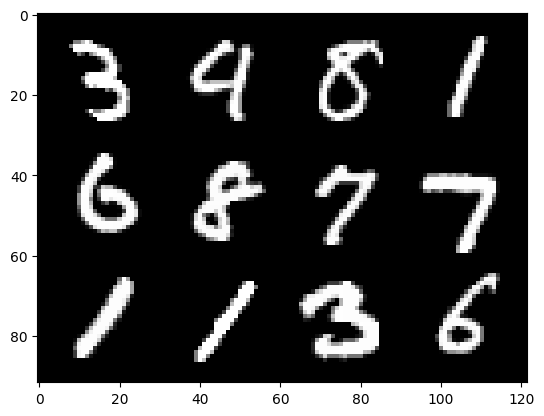


 tensor([ 4, 10,  9,  2,  7,  9,  8,  8,  2,  2,  4,  7], device='cuda:0')


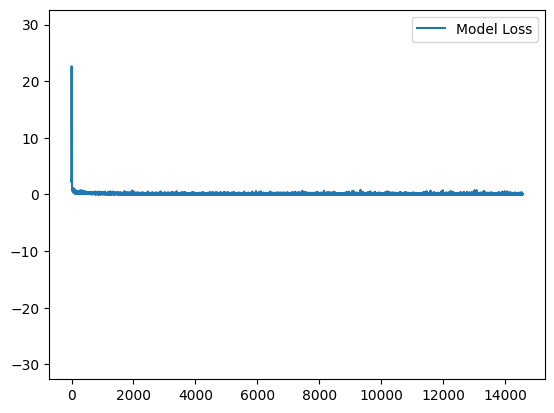

100%|██████████| 157/157 [00:01<00:00, 89.22it/s] 


Epoch 17/20, train loss 0.06380065537786891, train acc 98.37346428375837
 test loss 0.21246830453476653, test acc 96.44


 99%|█████████▉| 846/856 [00:06<00:00, 139.99it/s]


 Epoch: 17: Step 854: Model loss: 0.03709004446864128


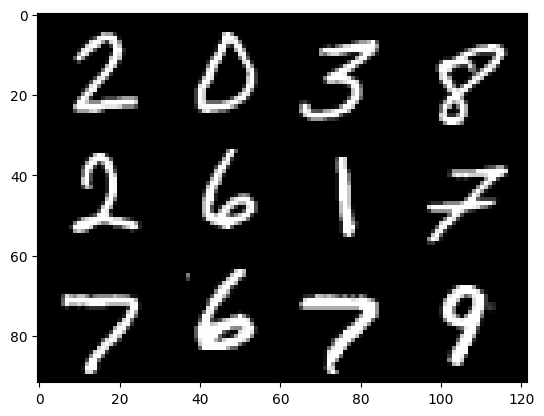


 tensor([ 3,  1,  4,  9,  3,  7,  2,  8,  8,  7,  8, 10], device='cuda:0')


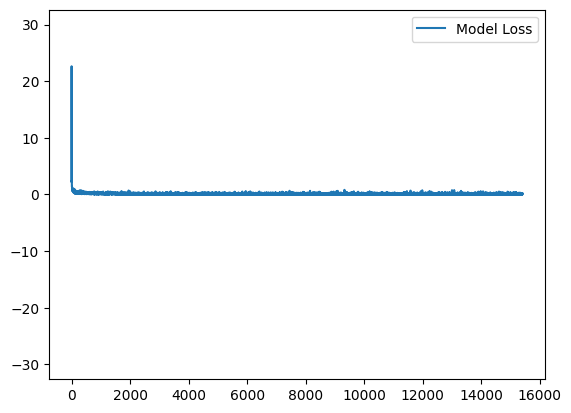

100%|██████████| 157/157 [00:01<00:00, 102.55it/s]


Epoch 18/20, train loss 0.06280164152333731, train acc 98.44100841563372
 test loss 0.1562364000334348, test acc 96.31


 98%|█████████▊| 842/856 [00:07<00:00, 142.30it/s]


 Epoch: 18: Step 854: Model loss: 0.03709004446864128


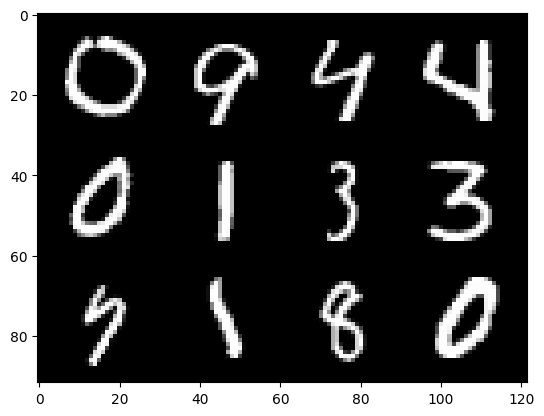


 tensor([ 1, 10,  5,  5,  1,  2,  4,  4,  8,  2,  9,  1], device='cuda:0')


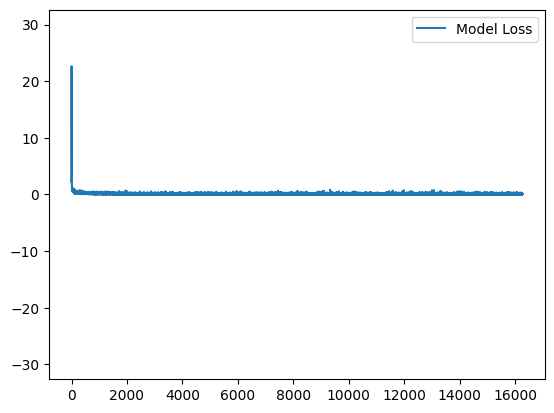

100%|██████████| 157/157 [00:01<00:00, 101.90it/s]


Epoch 19/20, train loss 0.06636446607118696, train acc 98.33512842512641
 test loss 0.0964287449460012, test acc 97.65


 99%|█████████▉| 846/856 [00:06<00:00, 118.29it/s]


 Epoch: 19: Step 854: Model loss: 0.03709004446864128


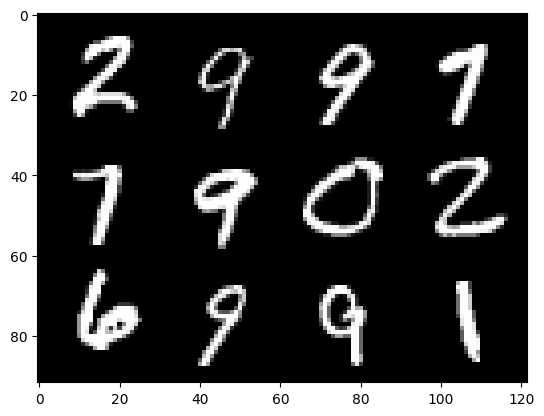


 tensor([ 3, 10, 10,  8,  8, 10,  1,  3,  7, 10, 10,  2], device='cuda:0')


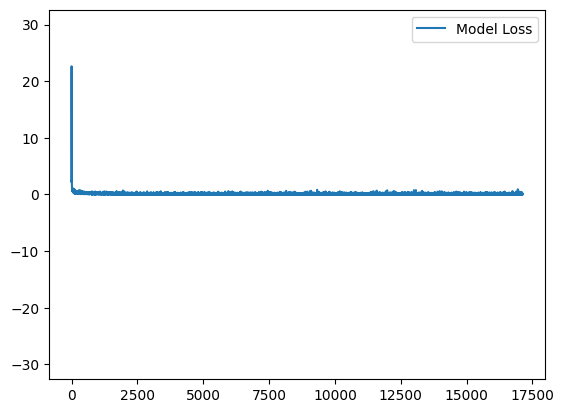

100%|██████████| 157/157 [00:02<00:00, 77.85it/s]

Epoch 20/20, train loss 0.06501379718534633, train acc 98.38806842038007
 test loss 0.10462158786136731, test acc 97.27


In [ ]:
epochs = 20
total_loss = []

train_loss = []
train_acc = []
test_loss = []
test_acc = []

step = 0
total_steps = int(ceil(len(train_dev_sets) / bs))
print_step = int(total_steps) - 2
show_step = int(total_steps) - 1


for epoch in range(epochs):

  step = 0
  correct = 0
  iter_loss = 0.0

  model.train()

  for i, (imgs, labels) in enumerate(tqdm(train_dev_loader)):
  #for i, (imgs, labels) in enumerate(tqdm(trainloader)):
    # pass data to gpu
    imgs = imgs.to(device)
    labels = labels.to(device)

    # get prediction
    preds = model(imgs)

    # calculate loss
    optimizer.zero_grad()
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    # store loss
    iter_loss += loss.item()
    total_loss += [loss.item()]

    _, predicted = torch.max(preds, dim=1)
    correct += (predicted == labels).sum().item()

    # Display results
    if step % print_step == 0 and step > 0:
      print(f"\n Epoch: {epoch}: Step {step}: Model loss: {total_loss[step]}")

    if step % print_step == 0 and step > 0:
      #save_checkpoint('latest_wgan_celeba')
      with torch.no_grad():
        sample_imgs = imgs[:12]
        show(sample_imgs, 12)

        preds = model(sample_imgs)
        out, inds = torch.max(preds,dim=1)
        inds = inds.add(1)
        print(f'\n {inds}')

    if step % show_step == 0 and step> 0:
      plt.plot(
            range(len(total_loss)),
            torch.Tensor(total_loss),
            label="Model Loss"
        )
      y=max(total_loss) + 10

      plt.ylim(-y,y)
      plt.legend()
      plt.show()

    step += 1

  train_loss.append(iter_loss / step)
  train_acc.append(100 *(correct / len(train_dev_sets)))

  #if epoch % 10 == 0 and epoch > 0:
  #  save_checkpoint('mnist_clf_vf_dropout')


  # Testing phase

  t_loss = 0.0
  step = 0
  correct = 0

  model.eval()

  for i, (imgs, labels) in enumerate(tqdm(testloader)):
    # pass data to gpu
    imgs = imgs.to(device)
    labels = labels.to(device)

    # get prediction
    preds = model(imgs)

    # calculate loss
    loss = loss_fn(preds, labels)

    # store loss
    t_loss += loss.item()

    _, predicted = torch.max(preds, dim=1)
    correct += (predicted == labels).sum().item()

    step += 1

  test_loss.append(t_loss / step)
  test_acc.append((100 * correct / len(test_dataset)))

  print(f'Epoch {epoch+1}/{epochs}, train loss {train_loss[-1]}, train acc {train_acc[-1]}')
  print(f' test loss {test_loss[-1]}, test acc {test_acc[-1]}')


Plotting Results

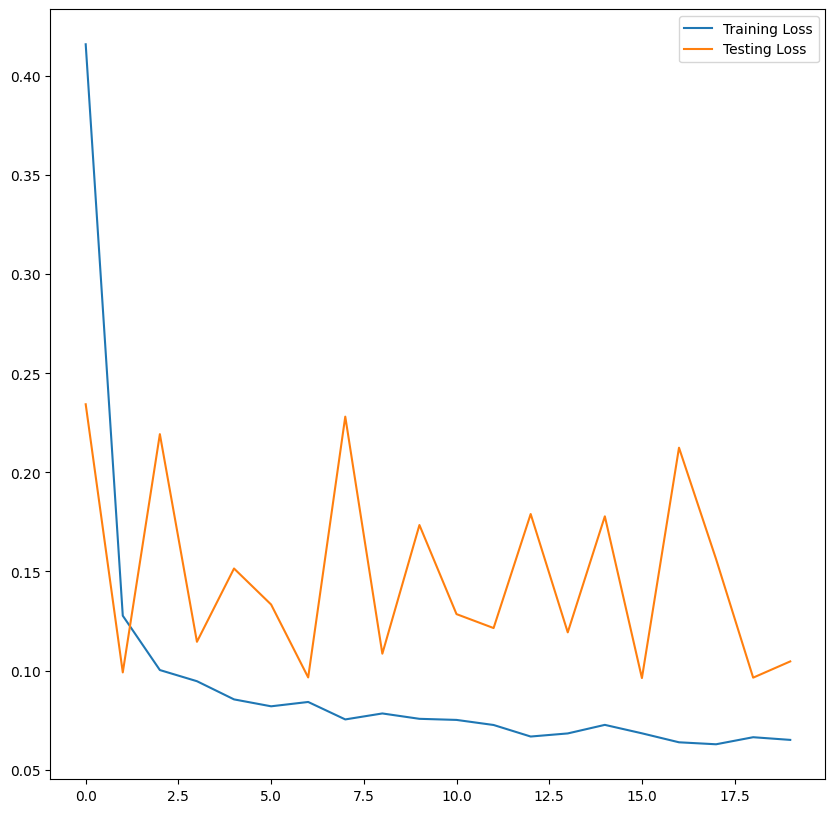

In [ ]:
f = plt.figure(figsize = (10, 10))
plt.plot(train_loss, label = 'Training Loss')
plt.plot(test_loss, label = 'Testing Loss')
plt.legend()
plt.show()

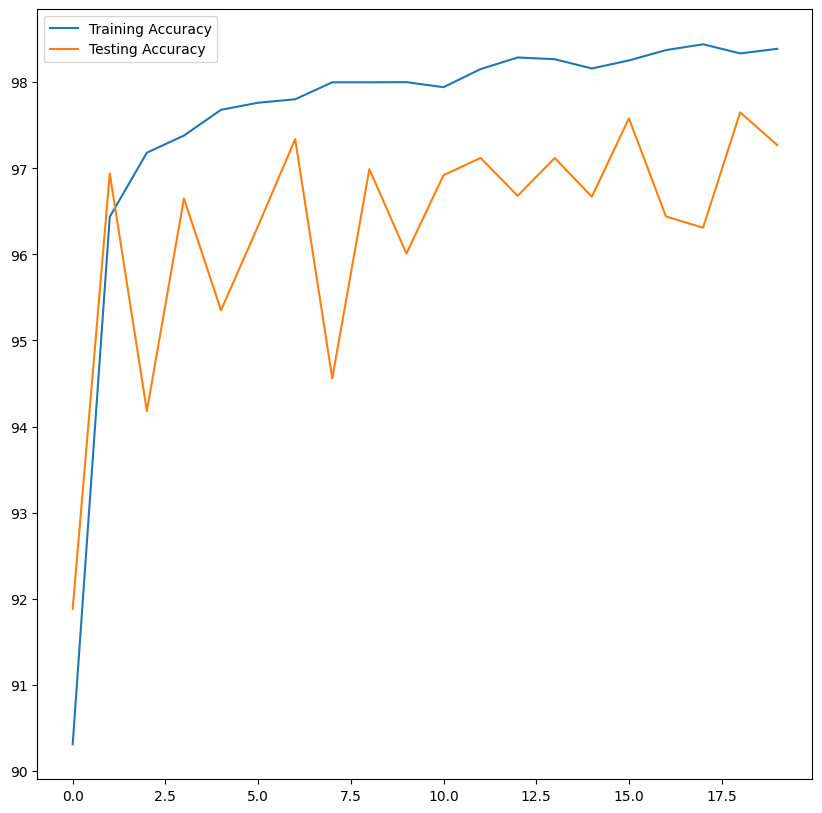

In [ ]:
f = plt.figure(figsize = (10, 10))
plt.plot(train_acc, label = 'Training Accuracy')
plt.plot(test_acc, label = 'Testing Accuracy')
plt.legend()
plt.show()

Save Checkpoints

In [ ]:
# (Optional)

# save and load checkpoints

#root_path='./data/'

from google.colab import drive
#drive.mount('/content/gdrive')
root_path='/content/drive/MyDrive/Colab/models'

def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      #'level': level,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict()
  }, f'{root_path}CLF_MNIST-{name}.pkl')

  print('Saved checkpoint')

def load_checkpoint(name):
  checkpoint = torch.load(f'{root_path}CLF_MNIST-{name}.pkl')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  #epoch = checkpoint['epoch']

  print('Loaded checkpoint')
  return checkpoint

Confusion Matrix

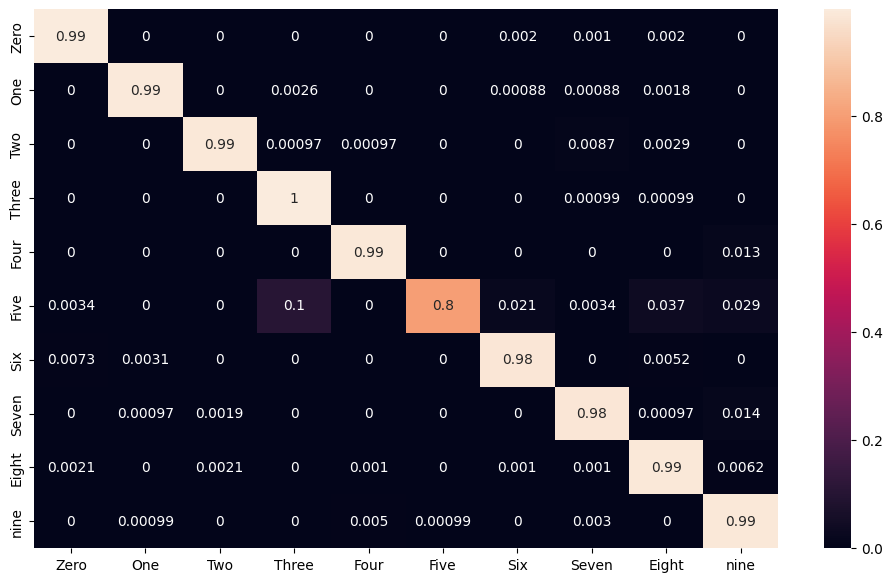

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data

for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        output =  model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Zero', 'One', 'Two', 'Three', 'Four',
        'Five', 'Six', 'Seven', 'Eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

plt.savefig('output.png')

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

np.random.seed(0)

X, y = next(iter(testloader))
X = X.to(device)
y = y.to(device)

# Fit the model
y_scores = model(X)

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# One hot encode the labels in order to plot them
#y_onehot = pd.get_dummies(y.detach().cpu(), classes)
y_onehot = torch.nn.functional.one_hot(y.detach().cpu(), num_classes=- 1)
y_onehot = pd.DataFrame(y_onehot.numpy())
#print(y.detach().cpu()[:10])
print(y_onehot[:10])

# Create an empty figure, and iteratively add new lines
# every time we compute a new class
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score.detach().cpu())
    auc_score = roc_auc_score(y_true, y_score.detach().cpu())

    name = f"{y_onehot.columns[i]} (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500
)
fig.show()

   0  1  2  3  4  5  6  7  8  9
0  0  0  0  0  0  0  0  1  0  0
1  0  0  1  0  0  0  0  0  0  0
2  0  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  0  0  0  0  1  0  0  0  0  0
5  0  1  0  0  0  0  0  0  0  0
6  0  0  0  0  1  0  0  0  0  0
7  0  0  0  0  0  0  0  0  0  1
8  0  0  0  0  0  1  0  0  0  0
9  0  0  0  0  0  0  0  0  0  1
